In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 pfcye2eb


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pfcye2eb:best, 314.55MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_ftr = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_ftr = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_ftr = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_ftr = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_ftr = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_ftr.extend(ftr.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_ftr.extend(ftr.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_ftr.extend(ftr.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            ftr, emb, lgt = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_ftr.extend(ftr.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_ftr.extend(ftr.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                         | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                | 1/685 [00:01<13:30,  1.19s/it]

  1%|█                                                                                                                                                | 5/685 [00:01<02:14,  5.05it/s]

  1%|██                                                                                                                                              | 10/685 [00:01<01:02, 10.80it/s]

  2%|███▏                                                                                                                                            | 15/685 [00:01<00:40, 16.63it/s]

  3%|████▏                                                                                                                                           | 20/685 [00:01<00:29, 22.33it/s]

  4%|█████▎                                                                                                                                          | 25/685 [00:01<00:23, 27.52it/s]

  4%|██████▎                                                                                                                                         | 30/685 [00:01<00:20, 31.97it/s]

  5%|███████▎                                                                                                                                        | 35/685 [00:01<00:18, 35.60it/s]

  6%|████████▍                                                                                                                                       | 40/685 [00:02<00:16, 38.47it/s]

  7%|█████████▍                                                                                                                                      | 45/685 [00:02<00:15, 40.66it/s]

  7%|██████████▌                                                                                                                                     | 50/685 [00:02<00:15, 42.30it/s]

  8%|███████████▌                                                                                                                                    | 55/685 [00:02<00:14, 43.47it/s]

  9%|████████████▌                                                                                                                                   | 60/685 [00:02<00:14, 44.35it/s]

  9%|█████████████▋                                                                                                                                  | 65/685 [00:02<00:13, 45.01it/s]

 10%|██████████████▋                                                                                                                                 | 70/685 [00:02<00:13, 45.47it/s]

 11%|███████████████▊                                                                                                                                | 75/685 [00:02<00:13, 45.81it/s]

 12%|████████████████▊                                                                                                                               | 80/685 [00:02<00:13, 45.88it/s]

 12%|█████████████████▊                                                                                                                              | 85/685 [00:03<00:13, 45.88it/s]

 13%|██████████████████▉                                                                                                                             | 90/685 [00:03<00:12, 45.90it/s]

 14%|███████████████████▉                                                                                                                            | 95/685 [00:03<00:12, 45.91it/s]

 15%|████████████████████▉                                                                                                                          | 100/685 [00:03<00:12, 45.92it/s]

 15%|█████████████████████▉                                                                                                                         | 105/685 [00:03<00:12, 45.93it/s]

 16%|██████████████████████▉                                                                                                                        | 110/685 [00:03<00:12, 46.09it/s]

 17%|████████████████████████                                                                                                                       | 115/685 [00:03<00:12, 46.26it/s]

 18%|█████████████████████████                                                                                                                      | 120/685 [00:03<00:12, 46.24it/s]

 18%|██████████████████████████                                                                                                                     | 125/685 [00:03<00:12, 46.22it/s]

 19%|███████████████████████████▏                                                                                                                   | 130/685 [00:03<00:12, 46.17it/s]

 20%|████████████████████████████▏                                                                                                                  | 135/685 [00:04<00:11, 46.15it/s]

 20%|█████████████████████████████▏                                                                                                                 | 140/685 [00:04<00:11, 46.27it/s]

 21%|██████████████████████████████▎                                                                                                                | 145/685 [00:04<00:11, 46.35it/s]

 22%|███████████████████████████████▎                                                                                                               | 150/685 [00:04<00:11, 46.40it/s]

 23%|████████████████████████████████▎                                                                                                              | 155/685 [00:04<00:11, 46.43it/s]

 23%|█████████████████████████████████▍                                                                                                             | 160/685 [00:04<00:11, 46.46it/s]

 24%|██████████████████████████████████▍                                                                                                            | 165/685 [00:04<00:11, 46.47it/s]

 25%|███████████████████████████████████▍                                                                                                           | 170/685 [00:04<00:11, 46.48it/s]

 26%|████████████████████████████████████▌                                                                                                          | 175/685 [00:04<00:10, 46.50it/s]

 26%|█████████████████████████████████████▌                                                                                                         | 180/685 [00:05<00:10, 46.54it/s]

 27%|██████████████████████████████████████▌                                                                                                        | 185/685 [00:05<00:10, 46.56it/s]

 28%|███████████████████████████████████████▋                                                                                                       | 190/685 [00:05<00:10, 46.57it/s]

 28%|████████████████████████████████████████▋                                                                                                      | 195/685 [00:05<00:10, 46.55it/s]

 29%|█████████████████████████████████████████▊                                                                                                     | 200/685 [00:05<00:10, 46.52it/s]

 30%|██████████████████████████████████████████▊                                                                                                    | 205/685 [00:05<00:10, 46.52it/s]

 31%|███████████████████████████████████████████▊                                                                                                   | 210/685 [00:05<00:10, 46.56it/s]

 31%|████████████████████████████████████████████▉                                                                                                  | 215/685 [00:05<00:10, 46.56it/s]

 32%|█████████████████████████████████████████████▉                                                                                                 | 220/685 [00:05<00:09, 46.54it/s]

 33%|██████████████████████████████████████████████▉                                                                                                | 225/685 [00:06<00:09, 46.52it/s]

 34%|████████████████████████████████████████████████                                                                                               | 230/685 [00:06<00:09, 46.51it/s]

 34%|█████████████████████████████████████████████████                                                                                              | 235/685 [00:06<00:09, 46.53it/s]

 35%|██████████████████████████████████████████████████                                                                                             | 240/685 [00:06<00:09, 46.50it/s]

 36%|███████████████████████████████████████████████████▏                                                                                           | 245/685 [00:06<00:09, 46.47it/s]

 36%|████████████████████████████████████████████████████▏                                                                                          | 250/685 [00:06<00:09, 46.45it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                         | 255/685 [00:06<00:09, 46.45it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                        | 260/685 [00:06<00:09, 46.43it/s]

 39%|███████████████████████████████████████████████████████▎                                                                                       | 265/685 [00:06<00:09, 46.46it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                      | 270/685 [00:07<00:08, 46.45it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                     | 275/685 [00:07<00:08, 46.47it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                    | 280/685 [00:07<00:08, 46.46it/s]

 42%|███████████████████████████████████████████████████████████▍                                                                                   | 285/685 [00:07<00:08, 46.44it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                  | 290/685 [00:07<00:08, 46.46it/s]

 43%|█████████████████████████████████████████████████████████████▌                                                                                 | 295/685 [00:07<00:08, 46.47it/s]

 44%|██████████████████████████████████████████████████████████████▋                                                                                | 300/685 [00:07<00:08, 46.48it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                               | 305/685 [00:07<00:08, 46.51it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                              | 310/685 [00:07<00:08, 46.49it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 315/685 [00:07<00:07, 46.46it/s]

 47%|██████████████████████████████████████████████████████████████████▊                                                                            | 320/685 [00:08<00:07, 46.47it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                           | 325/685 [00:08<00:07, 46.14it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                          | 330/685 [00:08<00:07, 46.24it/s]

 49%|█████████████████████████████████████████████████████████████████████▉                                                                         | 335/685 [00:08<00:07, 46.32it/s]

 50%|██████████████████████████████████████████████████████████████████████▉                                                                        | 340/685 [00:08<00:07, 46.36it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                       | 345/685 [00:08<00:07, 46.40it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                      | 350/685 [00:08<00:07, 46.42it/s]

 52%|██████████████████████████████████████████████████████████████████████████                                                                     | 355/685 [00:08<00:07, 46.45it/s]

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                   | 360/685 [00:08<00:07, 46.43it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                  | 365/685 [00:09<00:06, 46.45it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 370/685 [00:09<00:06, 46.46it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▎                                                                | 375/685 [00:09<00:06, 46.48it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                               | 380/685 [00:09<00:06, 46.52it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                              | 385/685 [00:09<00:06, 46.52it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                             | 390/685 [00:09<00:06, 46.52it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▍                                                            | 395/685 [00:09<00:06, 46.55it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                           | 400/685 [00:09<00:06, 46.53it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                          | 405/685 [00:09<00:06, 46.49it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▌                                                         | 410/685 [00:10<00:05, 46.49it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▋                                                        | 415/685 [00:10<00:05, 46.47it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 420/685 [00:10<00:05, 46.48it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 425/685 [00:10<00:05, 46.47it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 430/685 [00:10<00:05, 46.46it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 435/685 [00:10<00:05, 46.47it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 440/685 [00:10<00:05, 46.46it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 445/685 [00:10<00:05, 46.45it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 450/685 [00:10<00:05, 46.46it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 455/685 [00:10<00:04, 46.41it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                               | 460/685 [00:11<00:04, 46.45it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████                                              | 465/685 [00:11<00:04, 46.48it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████                                             | 470/685 [00:11<00:04, 46.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 475/685 [00:11<00:04, 46.51it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 480/685 [00:11<00:04, 46.50it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 485/685 [00:11<00:04, 46.42it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 490/685 [00:11<00:04, 46.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 495/685 [00:11<00:04, 46.21it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 500/685 [00:11<00:04, 46.15it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 505/685 [00:12<00:03, 46.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 510/685 [00:12<00:03, 46.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 515/685 [00:12<00:03, 46.01it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 520/685 [00:12<00:03, 46.01it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 525/685 [00:12<00:03, 46.02it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 530/685 [00:12<00:03, 46.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 535/685 [00:12<00:03, 46.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 540/685 [00:12<00:03, 46.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 545/685 [00:12<00:03, 46.02it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 550/685 [00:13<00:02, 46.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 555/685 [00:13<00:02, 46.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 560/685 [00:13<00:02, 46.02it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 565/685 [00:13<00:02, 46.02it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 570/685 [00:13<00:02, 46.05it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 575/685 [00:13<00:02, 45.97it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 580/685 [00:13<00:02, 46.03it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 585/685 [00:13<00:02, 46.21it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 590/685 [00:13<00:02, 46.33it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 595/685 [00:14<00:01, 46.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 600/685 [00:14<00:01, 46.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 605/685 [00:14<00:01, 46.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 610/685 [00:14<00:01, 46.50it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 615/685 [00:14<00:01, 46.50it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 620/685 [00:14<00:01, 46.52it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 625/685 [00:14<00:01, 46.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 630/685 [00:14<00:01, 46.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 635/685 [00:14<00:01, 46.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 640/685 [00:14<00:00, 46.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 645/685 [00:15<00:00, 46.51it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 650/685 [00:15<00:00, 46.47it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 655/685 [00:15<00:00, 46.51it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 660/685 [00:15<00:00, 46.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 665/685 [00:15<00:00, 46.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 670/685 [00:15<00:00, 46.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/685 [00:15<00:00, 46.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 680/685 [00:15<00:00, 46.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:15<00:00, 43.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:16<00:00, 42.78it/s]

train - OK


  0%|                                                                                                                                                         | 0/172 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                | 1/172 [00:00<00:42,  4.00it/s]

  3%|█████                                                                                                                                            | 6/172 [00:00<00:08, 20.07it/s]

  6%|█████████▏                                                                                                                                      | 11/172 [00:00<00:05, 29.32it/s]

  9%|█████████████▍                                                                                                                                  | 16/172 [00:00<00:04, 35.04it/s]

 12%|█████████████████▌                                                                                                                              | 21/172 [00:00<00:03, 38.69it/s]

 15%|█████████████████████▊                                                                                                                          | 26/172 [00:00<00:03, 41.22it/s]

 18%|█████████████████████████▉                                                                                                                      | 31/172 [00:00<00:03, 42.91it/s]

 21%|██████████████████████████████▏                                                                                                                 | 36/172 [00:01<00:03, 44.04it/s]

 24%|██████████████████████████████████▎                                                                                                             | 41/172 [00:01<00:02, 44.80it/s]

 27%|██████████████████████████████████████▌                                                                                                         | 46/172 [00:01<00:02, 45.32it/s]

 30%|██████████████████████████████████████████▋                                                                                                     | 51/172 [00:01<00:02, 45.70it/s]

 33%|██████████████████████████████████████████████▉                                                                                                 | 56/172 [00:01<00:02, 45.65it/s]

 35%|███████████████████████████████████████████████████                                                                                             | 61/172 [00:01<00:02, 45.89it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 66/172 [00:01<00:02, 46.09it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                    | 71/172 [00:01<00:02, 46.25it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 76/172 [00:01<00:02, 46.21it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 81/172 [00:01<00:01, 46.05it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 86/172 [00:02<00:01, 46.17it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                   | 91/172 [00:02<00:01, 46.30it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 96/172 [00:02<00:01, 46.38it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▉                                                           | 101/172 [00:02<00:01, 46.46it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 106/172 [00:02<00:01, 46.49it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 111/172 [00:02<00:01, 46.52it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 116/172 [00:02<00:01, 46.52it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 121/172 [00:02<00:01, 46.48it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 126/172 [00:02<00:00, 46.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 131/172 [00:03<00:00, 46.28it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 136/172 [00:03<00:00, 46.35it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 141/172 [00:03<00:00, 46.41it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 146/172 [00:03<00:00, 46.46it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 151/172 [00:03<00:00, 46.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 156/172 [00:03<00:00, 46.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 161/172 [00:03<00:00, 46.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 166/172 [00:03<00:00, 46.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 171/172 [00:03<00:00, 46.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:04<00:00, 42.54it/s]

val - OK


  0%|                                                                                                                                                         | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                | 1/328 [00:00<01:30,  3.59it/s]

  2%|██▋                                                                                                                                              | 6/328 [00:00<00:17, 18.63it/s]

  3%|████▊                                                                                                                                           | 11/328 [00:00<00:11, 27.95it/s]

  5%|███████                                                                                                                                         | 16/328 [00:00<00:09, 33.95it/s]

  6%|█████████▏                                                                                                                                      | 21/328 [00:00<00:08, 37.93it/s]

  8%|███████████▍                                                                                                                                    | 26/328 [00:00<00:07, 40.37it/s]

  9%|█████████████▌                                                                                                                                  | 31/328 [00:00<00:07, 42.19it/s]

 11%|███████████████▊                                                                                                                                | 36/328 [00:01<00:06, 43.53it/s]

 12%|██████████████████                                                                                                                              | 41/328 [00:01<00:06, 44.45it/s]

 14%|████████████████████▏                                                                                                                           | 46/328 [00:01<00:06, 45.07it/s]

 16%|██████████████████████▍                                                                                                                         | 51/328 [00:01<00:06, 45.19it/s]

 17%|████████████████████████▌                                                                                                                       | 56/328 [00:01<00:05, 45.58it/s]

 19%|██████████████████████████▊                                                                                                                     | 61/328 [00:01<00:05, 45.87it/s]

 20%|████████████████████████████▉                                                                                                                   | 66/328 [00:01<00:05, 46.07it/s]

 22%|███████████████████████████████▏                                                                                                                | 71/328 [00:01<00:05, 46.07it/s]

 23%|█████████████████████████████████▎                                                                                                              | 76/328 [00:01<00:05, 46.01it/s]

 25%|███████████████████████████████████▌                                                                                                            | 81/328 [00:02<00:05, 46.18it/s]

 26%|█████████████████████████████████████▊                                                                                                          | 86/328 [00:02<00:05, 46.29it/s]

 28%|███████████████████████████████████████▉                                                                                                        | 91/328 [00:02<00:05, 46.39it/s]

 29%|██████████████████████████████████████████▏                                                                                                     | 96/328 [00:02<00:05, 46.08it/s]

 31%|████████████████████████████████████████████                                                                                                   | 101/328 [00:02<00:04, 46.19it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 106/328 [00:02<00:04, 46.29it/s]

 34%|████████████████████████████████████████████████▍                                                                                              | 111/328 [00:02<00:04, 46.36it/s]

 35%|██████████████████████████████████████████████████▌                                                                                            | 116/328 [00:02<00:04, 46.34it/s]

 37%|████████████████████████████████████████████████████▊                                                                                          | 121/328 [00:02<00:04, 46.13it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                        | 126/328 [00:02<00:04, 46.27it/s]

 40%|█████████████████████████████████████████████████████████                                                                                      | 131/328 [00:03<00:04, 46.38it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                   | 136/328 [00:03<00:04, 46.45it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                 | 141/328 [00:03<00:04, 46.49it/s]

 45%|███████████████████████████████████████████████████████████████▋                                                                               | 146/328 [00:03<00:03, 46.52it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 151/328 [00:03<00:03, 46.55it/s]

 48%|████████████████████████████████████████████████████████████████████                                                                           | 156/328 [00:03<00:03, 46.57it/s]

 49%|██████████████████████████████████████████████████████████████████████▏                                                                        | 161/328 [00:03<00:03, 46.55it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 166/328 [00:03<00:03, 46.21it/s]

 52%|██████████████████████████████████████████████████████████████████████████▌                                                                    | 171/328 [00:03<00:03, 46.29it/s]

 54%|████████████████████████████████████████████████████████████████████████████▋                                                                  | 176/328 [00:04<00:03, 46.34it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                | 181/328 [00:04<00:03, 46.39it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████                                                              | 186/328 [00:04<00:03, 46.29it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                           | 191/328 [00:04<00:02, 46.17it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 196/328 [00:04<00:02, 46.28it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                       | 201/328 [00:04<00:02, 46.39it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 206/328 [00:04<00:02, 46.46it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 211/328 [00:04<00:02, 46.14it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 216/328 [00:04<00:02, 46.25it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 221/328 [00:05<00:02, 46.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 226/328 [00:05<00:02, 46.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 231/328 [00:05<00:02, 46.48it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 236/328 [00:05<00:01, 46.50it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 241/328 [00:05<00:01, 46.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 246/328 [00:05<00:01, 46.58it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 251/328 [00:05<00:01, 46.58it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 256/328 [00:05<00:01, 46.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 261/328 [00:05<00:01, 46.32it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 266/328 [00:05<00:01, 46.41it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 271/328 [00:06<00:01, 46.45it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 276/328 [00:06<00:01, 46.39it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 281/328 [00:06<00:01, 46.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 286/328 [00:06<00:00, 46.30it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 291/328 [00:06<00:00, 46.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 296/328 [00:06<00:00, 46.47it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 301/328 [00:06<00:00, 46.28it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 306/328 [00:06<00:00, 46.26it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 311/328 [00:06<00:00, 46.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 316/328 [00:07<00:00, 46.46it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:07<00:00, 46.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 326/328 [00:07<00:00, 46.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:07<00:00, 44.00it/s]

test InD - OK


  0%|                                                                                                                                                         | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                | 1/437 [00:00<02:20,  3.09it/s]

  1%|█▉                                                                                                                                               | 6/437 [00:00<00:25, 16.95it/s]

  3%|███▌                                                                                                                                            | 11/437 [00:00<00:16, 26.23it/s]

  4%|█████▎                                                                                                                                          | 16/437 [00:00<00:12, 32.49it/s]

  5%|██████▉                                                                                                                                         | 21/437 [00:00<00:11, 36.77it/s]

  6%|████████▌                                                                                                                                       | 26/437 [00:00<00:10, 39.72it/s]

  7%|██████████▏                                                                                                                                     | 31/437 [00:00<00:09, 41.76it/s]

  8%|███████████▊                                                                                                                                    | 36/437 [00:01<00:09, 43.18it/s]

  9%|█████████████▌                                                                                                                                  | 41/437 [00:01<00:08, 44.18it/s]

 11%|███████████████▏                                                                                                                                | 46/437 [00:01<00:08, 44.70it/s]

 12%|████████████████▊                                                                                                                               | 51/437 [00:01<00:08, 45.06it/s]

 13%|██████████████████▍                                                                                                                             | 56/437 [00:01<00:08, 45.47it/s]

 14%|████████████████████                                                                                                                            | 61/437 [00:01<00:08, 45.77it/s]

 15%|█████████████████████▋                                                                                                                          | 66/437 [00:01<00:08, 46.00it/s]

 16%|███████████████████████▍                                                                                                                        | 71/437 [00:01<00:07, 45.79it/s]

 17%|█████████████████████████                                                                                                                       | 76/437 [00:01<00:07, 45.97it/s]

 19%|██████████████████████████▋                                                                                                                     | 81/437 [00:02<00:07, 46.13it/s]

 20%|████████████████████████████▎                                                                                                                   | 86/437 [00:02<00:07, 46.22it/s]

 21%|█████████████████████████████▉                                                                                                                  | 91/437 [00:02<00:07, 46.21it/s]

 22%|███████████████████████████████▋                                                                                                                | 96/437 [00:02<00:07, 46.03it/s]

 23%|█████████████████████████████████                                                                                                              | 101/437 [00:02<00:07, 46.18it/s]

 24%|██████████████████████████████████▋                                                                                                            | 106/437 [00:02<00:07, 46.27it/s]

 25%|████████████████████████████████████▎                                                                                                          | 111/437 [00:02<00:07, 46.35it/s]

 27%|█████████████████████████████████████▉                                                                                                         | 116/437 [00:02<00:06, 46.15it/s]

 28%|███████████████████████████████████████▌                                                                                                       | 121/437 [00:02<00:06, 46.13it/s]

 29%|█████████████████████████████████████████▏                                                                                                     | 126/437 [00:03<00:06, 46.26it/s]

 30%|██████████████████████████████████████████▊                                                                                                    | 131/437 [00:03<00:06, 46.32it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 136/437 [00:03<00:06, 46.34it/s]

 32%|██████████████████████████████████████████████▏                                                                                                | 141/437 [00:03<00:06, 46.07it/s]

 33%|███████████████████████████████████████████████▊                                                                                               | 146/437 [00:03<00:06, 46.19it/s]

 35%|█████████████████████████████████████████████████▍                                                                                             | 151/437 [00:03<00:06, 46.28it/s]

 36%|███████████████████████████████████████████████████                                                                                            | 156/437 [00:03<00:06, 46.36it/s]

 37%|████████████████████████████████████████████████████▋                                                                                          | 161/437 [00:03<00:05, 46.22it/s]

 38%|██████████████████████████████████████████████████████▎                                                                                        | 166/437 [00:03<00:05, 46.14it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                       | 171/437 [00:03<00:05, 46.25it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                     | 176/437 [00:04<00:05, 46.29it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                   | 181/437 [00:04<00:05, 46.38it/s]

 43%|████████████████████████████████████████████████████████████▊                                                                                  | 186/437 [00:04<00:05, 46.07it/s]

 44%|██████████████████████████████████████████████████████████████▌                                                                                | 191/437 [00:04<00:05, 46.18it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                              | 196/437 [00:04<00:05, 46.25it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 201/437 [00:04<00:05, 46.32it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 206/437 [00:04<00:04, 46.31it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 211/437 [00:04<00:04, 46.08it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 216/437 [00:04<00:04, 46.18it/s]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                      | 221/437 [00:05<00:04, 46.26it/s]

 52%|█████████████████████████████████████████████████████████████████████████▉                                                                     | 226/437 [00:05<00:04, 46.36it/s]

 53%|███████████████████████████████████████████████████████████████████████████▌                                                                   | 231/437 [00:05<00:04, 46.13it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                 | 236/437 [00:05<00:04, 46.15it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                | 241/437 [00:05<00:04, 46.24it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                              | 246/437 [00:05<00:04, 46.35it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                            | 251/437 [00:05<00:04, 46.36it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▊                                                           | 256/437 [00:05<00:03, 46.41it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▍                                                         | 261/437 [00:05<00:03, 46.44it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████                                                        | 266/437 [00:06<00:03, 46.46it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 271/437 [00:06<00:03, 46.51it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 276/437 [00:06<00:03, 46.24it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 281/437 [00:06<00:03, 46.22it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 286/437 [00:06<00:03, 46.31it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 291/437 [00:06<00:03, 46.40it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 296/437 [00:06<00:03, 46.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 301/437 [00:06<00:02, 46.23it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 306/437 [00:06<00:02, 46.05it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 311/437 [00:07<00:02, 45.72it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 316/437 [00:07<00:02, 45.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 321/437 [00:07<00:02, 45.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 326/437 [00:07<00:02, 45.91it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 331/437 [00:07<00:02, 45.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 336/437 [00:07<00:02, 45.99it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 341/437 [00:07<00:02, 45.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 346/437 [00:07<00:01, 45.73it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 351/437 [00:07<00:01, 45.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 356/437 [00:08<00:01, 45.92it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 361/437 [00:08<00:01, 45.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 366/437 [00:08<00:01, 45.94it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 371/437 [00:08<00:01, 45.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 376/437 [00:08<00:01, 46.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 381/437 [00:08<00:01, 45.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 386/437 [00:08<00:01, 45.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 391/437 [00:08<00:01, 45.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 396/437 [00:08<00:00, 45.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 401/437 [00:08<00:00, 45.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 406/437 [00:09<00:00, 45.60it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 411/437 [00:09<00:00, 45.72it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 416/437 [00:09<00:00, 45.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 421/437 [00:09<00:00, 45.89it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 426/437 [00:09<00:00, 45.94it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 431/437 [00:09<00:00, 45.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:09<00:00, 45.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:09<00:00, 44.06it/s]

test OoD - OK


  0%|                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

  6%|████████▋                                                                                                                                        | 6/100 [00:00<00:01, 51.43it/s]

 12%|█████████████████▎                                                                                                                              | 12/100 [00:00<00:01, 51.53it/s]

 18%|█████████████████████████▉                                                                                                                      | 18/100 [00:00<00:01, 51.64it/s]

 24%|██████████████████████████████████▌                                                                                                             | 24/100 [00:00<00:01, 51.68it/s]

 30%|███████████████████████████████████████████▏                                                                                                    | 30/100 [00:00<00:01, 51.71it/s]

 36%|███████████████████████████████████████████████████▊                                                                                            | 36/100 [00:00<00:01, 51.76it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                   | 42/100 [00:00<00:01, 51.79it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                           | 48/100 [00:00<00:01, 51.83it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 54/100 [00:01<00:00, 51.82it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 60/100 [00:01<00:00, 51.84it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 66/100 [00:01<00:00, 51.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 72/100 [00:01<00:00, 51.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 78/100 [00:01<00:00, 51.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 84/100 [00:01<00:00, 51.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 90/100 [00:01<00:00, 51.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 96/100 [00:01<00:00, 51.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.82it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr).squeeze()
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr).squeeze()
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr).squeeze()
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr).squeeze()
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr).squeeze()
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(87612, 3, 64, 64) (87612, 2048) (87612, 512) (87612, 2) (87612,)
(21905, 3, 64, 64) (21905, 2048) (21905, 512) (21905, 2) (21905,)
(41868, 3, 64, 64) (41868, 2048) (41868, 512) (41868, 2) (41868,)
(55824, 3, 64, 64) (55824, 2048) (55824, 512) (55824, 2) (55824,)
(12800, 3, 64, 64) (12800, 2048) (12800, 512) (12800, 2)


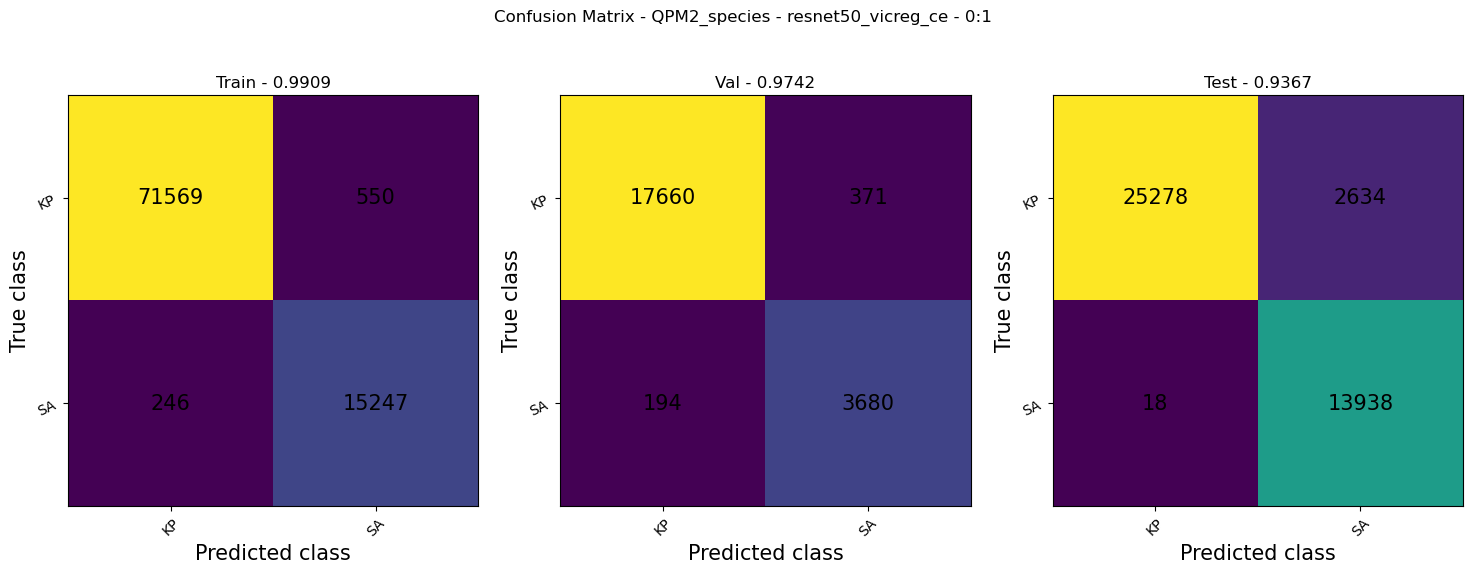

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_ftr.shape[0]
all_ftr = ind_ftr
all_lgt = ind_lgt
if ood_str:
    all_ftr = np.concatenate([all_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_ftr2d = umap.fit_transform(all_ftr)
ind_ftr2d = np.array(all_ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(all_ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)
(41868, 2) (55824, 2)


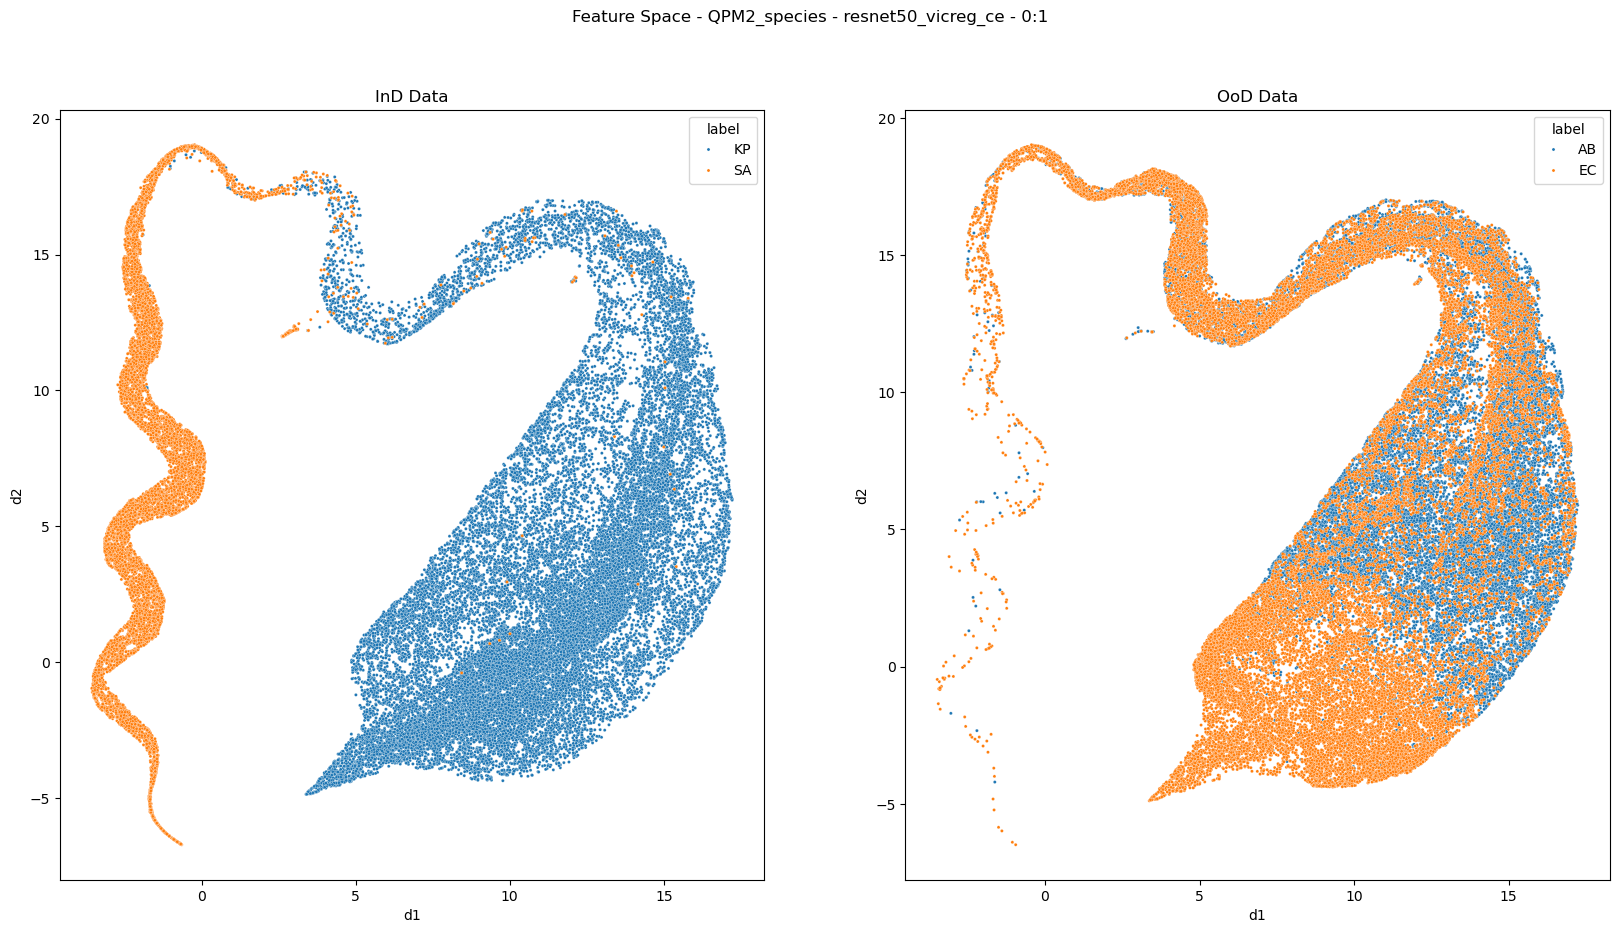

In [13]:
# plot feature space
df_ftr2d = pd.DataFrame()
d1, d2 = ind_ftr2d.T
df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    df_ftr2d = pd.concat([df_ftr2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_ftr2d[(df_ftr2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

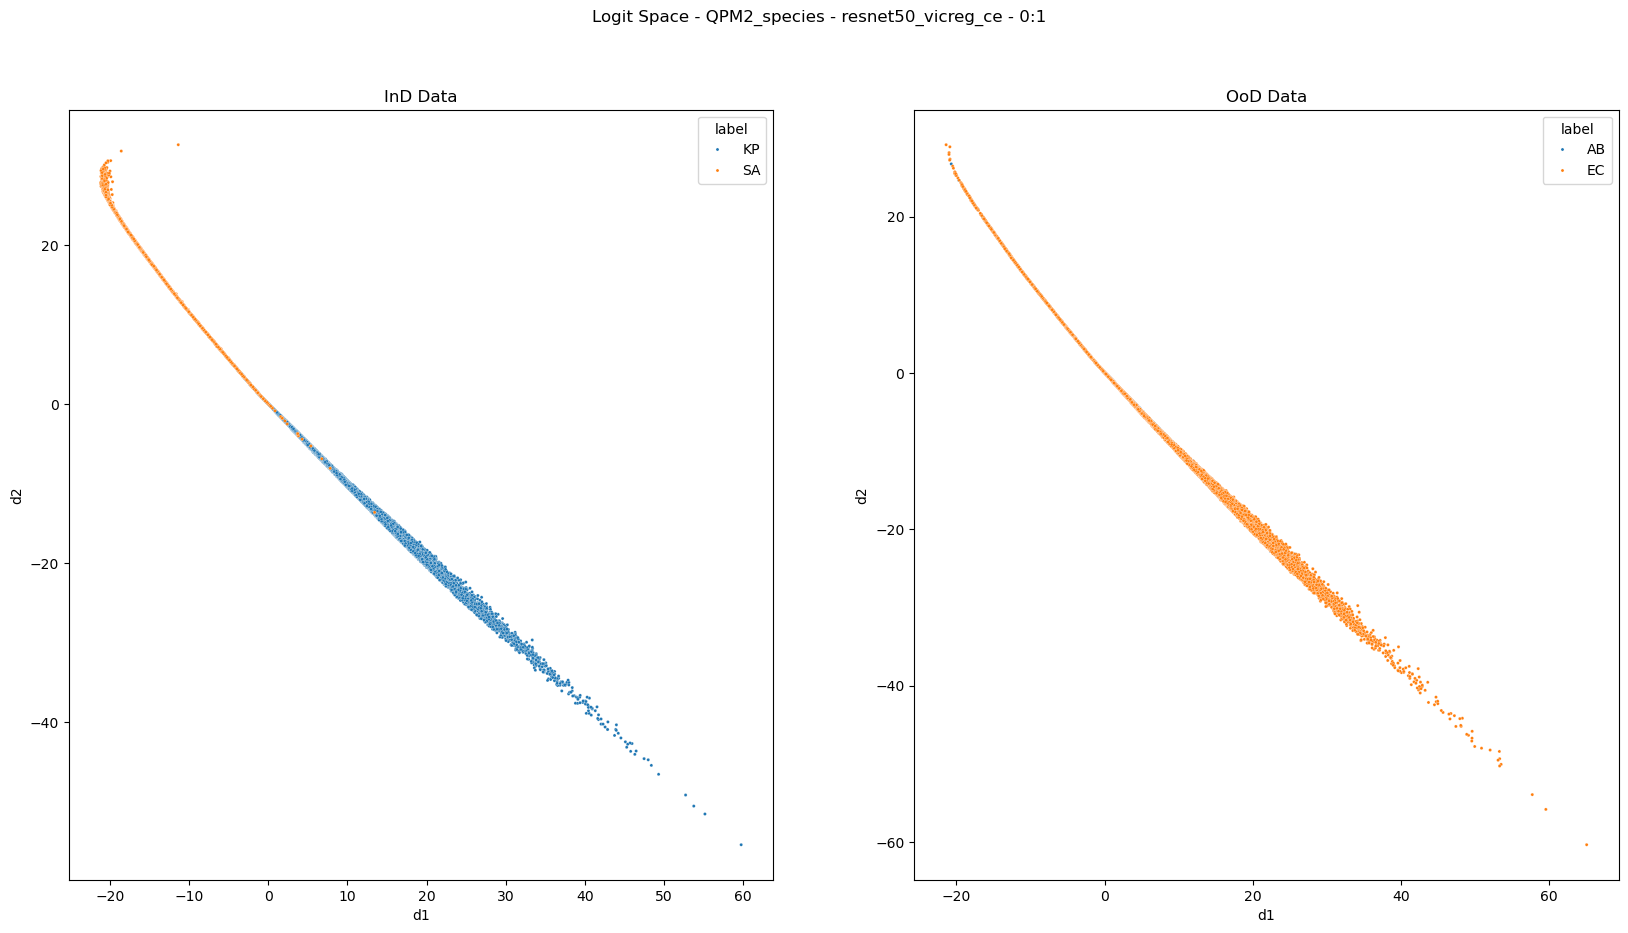

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

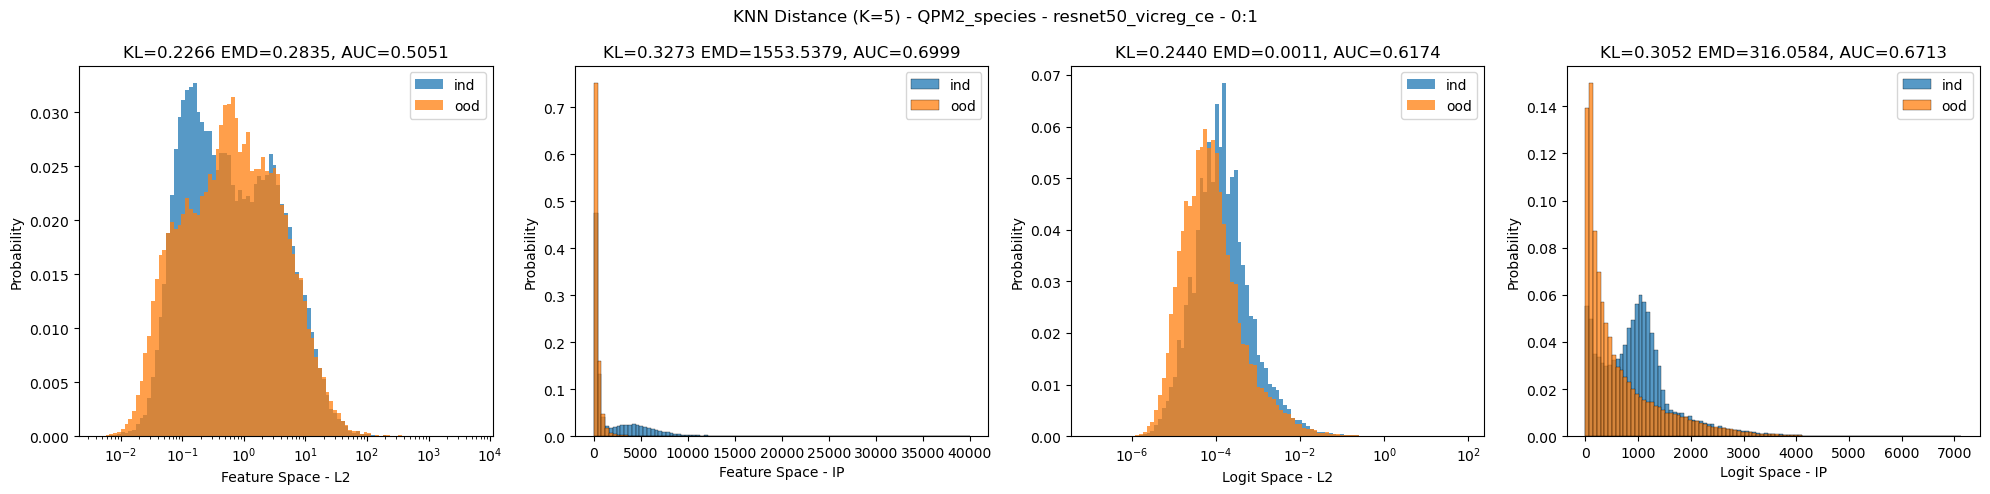

In [15]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_ftr, val_ftr, ind_ftr, ood_ftr if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

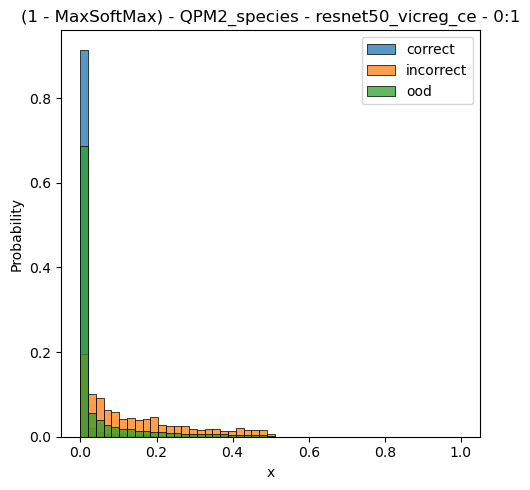

In [16]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [17]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)